In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import os
import geopandas as gpd
import rioxarray
import hvplot.xarray 
import pandas as pd

In [2]:
# !mkdir -p /inputs/CHIRPS
# !for y in $(seq 1997 1998); do wget -nc -P /inputs/CHIRPS "http://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/chirps-v2.0.${y}.days_p05.nc"; done

In [3]:
path_shapefiles = Path('../MSWEP/shapefiles')

In [4]:
basins_mapping = {
    'paso_mazangano': 'CAMELS_UY_10',
    'picada_de_coelho': 'CAMELS_UY_7',
    'sarandi_del_yi': 'CAMELS_UY_12',
    'paso_de_las_toscas': 'CAMELS_UY_8',
    'paso_de_las_piedras_rn': 'CAMELS_UY_15',
    'paso_del_borracho': 'CAMELS_UY_6',
    'bequelo': 'CAMELS_UY_16',
    'paso_de_las_piedras': 'CAMELS_UY_2',
    'paso_baltasar': 'CAMELS_UY_5',
    'fraile_muerto': 'CAMELS_UY_11',
    'paso_de_los_mellizos': 'CAMELS_UY_14',
    'paso_manuel_diaz': 'CAMELS_UY_3',
    'paso_aguiar': 'CAMELS_UY_9',
    'paso_de_la_compania': 'CAMELS_UY_1',
    'tacuarembo': 'CAMELS_UY_4',
    'durazno': 'CAMELS_UY_13'
}

In [5]:
shapefiles = os.listdir(path_shapefiles)
shapefiles=shapefiles[1:]
shapefiles

['paso_de_las_piedras.zip',
 'paso_de_la_compania.zip',
 'fraile_muerto.zip',
 'paso_aguiar.zip',
 'mercedes.zip',
 'bequelo.zip',
 'sarandi_del_yi.zip',
 'paso_manuel_diaz.zip',
 'paso_de_los_mellizos.zip',
 'paso_de_las_toscas.zip',
 'paso_del_borracho.zip',
 'picada_de_coelho.zip',
 'paso_mazangano.zip',
 'paso_de_las_piedras_rn.zip',
 'paso_baltasar.zip',
 'tacuarembo.zip']

In [5]:
ds = xr.open_dataset("chirps-v2.0.2024.days_p05.nc")
precip = ds["precip"]
precip

<xarray.DataArray 'precip' (time: 366, latitude: 2000, longitude: 7200)> Size: 21GB
[5270400000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 8kB -49.97 -49.92 -49.88 ... 49.87 49.92 49.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time       (time) datetime64[ns] 3kB 2024-01-01 2024-01-02 ... 2024-12-31
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

In [6]:
precip_sel=precip.sel(time="2024-07-30")  # get January 1
precip_sel

<xarray.DataArray 'precip' (latitude: 2000, longitude: 7200)> Size: 58MB
[14400000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 8kB -49.97 -49.92 -49.88 ... 49.87 49.92 49.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
    time       datetime64[ns] 8B 2024-07-30
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

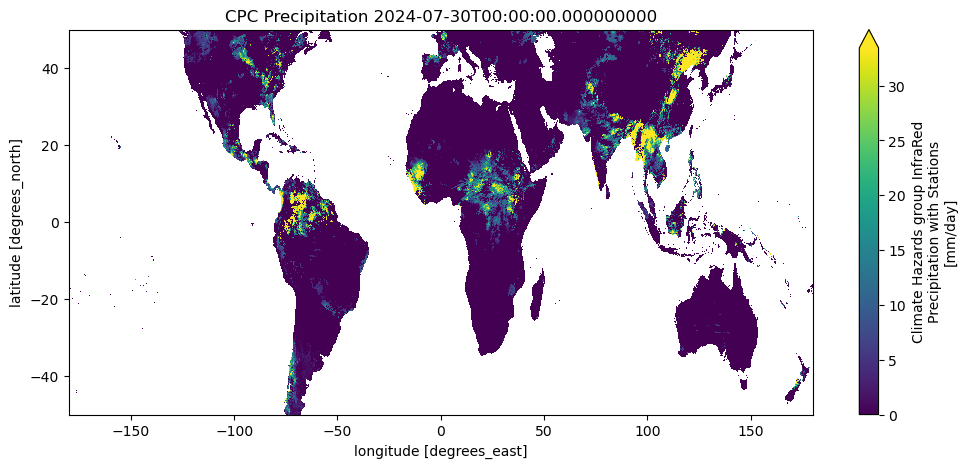

In [7]:
fig, ax = plt.subplots(figsize=(12,5))
precip_sel.plot(
    ax=ax,
    x="longitude", y="latitude",
    cmap="viridis",
    robust=True,   # avoids extreme outliers messing up colors
)
ax.set_title(f"CPC Precipitation {precip_sel.time.values}")
plt.show()

# # Interactive plot
# precip_sel.hvplot.image(
#     x="lon",
#     y="lat",
#     cmap="viridis",
#     width=600,
#     height=400,
#     interactive=True
# )

In [8]:
precip_sel

<xarray.DataArray 'precip' (latitude: 2000, longitude: 7200)> Size: 58MB
[14400000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 8kB -49.97 -49.92 -49.88 ... 49.87 49.92 49.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
    time       datetime64[ns] 8B 2024-07-30
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

In [9]:
path_shapefiles = Path('../MSWEP/shapefiles')
shp_file = path_shapefiles / 'paso_de_las_piedras.zip'  # example

# Load with geopandas
gdf = gpd.read_file(shp_file)

In [10]:
gdf.bounds

,minx,miny,maxx,maxy
0,-55.722917,-31.532917,-55.237083,-30.832917


In [11]:
# Give the DataArray a CRS
precip_sel.rio.write_crs("EPSG:4326", inplace=True)

# Tell rioxarray which dims are spatial
precip_sel = precip_sel.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")

# Merge geometry (in case shapefile has multiple polygons)
geometry = gdf.union_all() #.buffer(0.25)

# Clip
precip_clipped = precip_sel.rio.clip([geometry], precip_sel.rio.crs, drop=True)

In [12]:
precip_clipped

<xarray.DataArray 'precip' (latitude: 14, longitude: 9)> Size: 504B
array([[nan, nan,  0., nan, nan, nan, nan, nan, nan],
       [nan,  0.,  0.,  0.,  0., nan, nan, nan, nan],
       [ 0.,  0.,  0.,  0.,  0.,  0., nan, nan, nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., nan, nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan],
       [nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan,  0.,  0.,  0.,  0.,  0., nan, nan],
       [nan, nan,  0.,  0.,  0.,  0.,  0., nan, nan],
       [nan, nan,  0.,  0.,  0.,  0.,  0., nan, nan],
       [nan, nan,  0.,  0.,  0., nan, nan, nan, nan],
       [nan,  0.,  0.,  0., nan, nan, nan, nan, nan],
       [nan,  0.,  0., nan, nan, nan, nan, nan, nan]], dtype=float32)
Coordinates:
  * latitude     (latitude) float32 56B -31.52 -31.48 -31.42 ... -30.92 -30.88
  * longitude    (longitude) float32 36B -55.68 -55.63 -55.58 ... -55.33 -55.28
    time         datetime64[ns] 8B 2024-07-30
    spatial_ref  int64 8B 0
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

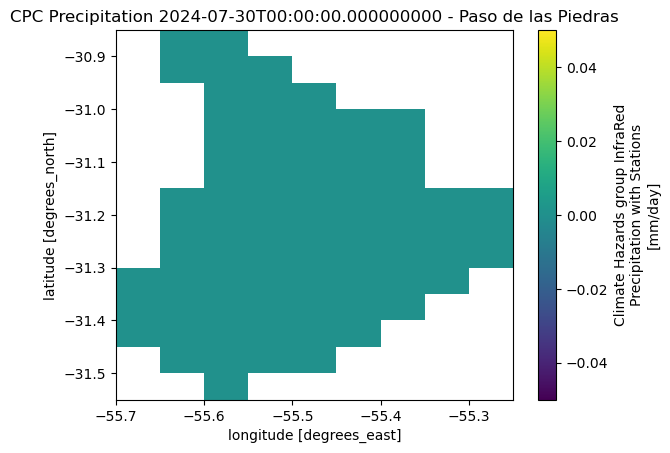

In [13]:
precip_clipped.plot(cmap="viridis", robust=True)
plt.title(f"CPC Precipitation {precip_clipped.time.values} - Paso de las Piedras")
plt.show()

# Creating the timeseries

In [ ]:
# import xarray as xr
# import geopandas as gpd
# import regionmask
# import pandas as pd
# from pathlib import Path

# # shapefile
# path_shapefiles = Path('../MSWEP/shapefiles')
# shp_file = path_shapefiles / 'paso_de_las_piedras.zip'
# gdf = gpd.read_file(shp_file).to_crs("EPSG:4326")
# geom = gdf.union_all()

# # CHIRPS folder
# chirps_folder = Path('/inputs/CHIRPS/')
# years = range(1989, 2020)  # 1989-2019

# all_ts = []

# # create mask once (for the grid of the first file)
# first_file = chirps_folder / f"chirps-v2.0.{years[0]}.days_p05.nc"
# ds0 = xr.open_dataset(first_file)
# pr0 = ds0["precip"]
# minx, miny, maxx, maxy = geom.bounds
# pr0 = pr0.sel(longitude=slice(minx-0.2, maxx+0.2),
#               latitude=slice(miny-0.2, maxy+0.2))
# mask = regionmask.mask_geopandas(gdf, pr0.longitude, pr0.latitude)

# # loop over years
# for year in years:
#     file = chirps_folder / f"chirps-v2.0.{year}.days_p05.nc"
#     ds = xr.open_dataset(file)
#     pr = ds["precip"]

#     # subset bbox (same as first file)
#     pr = pr.sel(longitude=slice(minx-0.2, maxx+0.2),
#                 latitude=slice(miny-0.2, maxy+0.2))

#     # apply mask
#     pr_basin = pr.where(mask == 0)

#     # basin-averaged time series
#     ts = pr_basin.mean(dim=("latitude", "longitude")).to_series()
#     all_ts.append(ts)

# # concatenate all years
# full_ts = pd.concat(all_ts)
# full_ts.name = "precipitation"

# # save CSV
# full_ts.to_csv("paso_de_las_piedras_precip_1989_2019.csv", header=True)


getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1990.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1991.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1992.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1993.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1994.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1995.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1996.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1997.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1998.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1999.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.2000.days_p05.n

In [11]:
exclude_basins = [
    'mercedes',
    'paso_de_las_piedras',
    'paso_de_la_compania',
    'fraile_muerto',
    'durazno',
    'paso_aguiar'
]

In [12]:
import xarray as xr
import geopandas as gpd
import regionmask
import pandas as pd
from pathlib import Path
import os

# shapefiles folder
path_shapefiles = Path('../MSWEP/shapefiles')

# CHIRPS folder
chirps_folder = Path('/inputs/CHIRPS/')
years = range(1989, 2020)  # 1989-2019

# Output directory
output_dir = Path('./precip_timeseries')
output_dir.mkdir(exist_ok=True)

# Mapping shapefile names to CAMELS_UY IDs
basins_mapping = {
    'paso_mazangano': 'CAMELS_UY_10',
    'picada_de_coelho': 'CAMELS_UY_7',
    'sarandi_del_yi': 'CAMELS_UY_12',
    'paso_de_las_toscas': 'CAMELS_UY_8',
    'paso_de_las_piedras_rn': 'CAMELS_UY_15',
    'paso_del_borracho': 'CAMELS_UY_6',
    'bequelo': 'CAMELS_UY_16',
    'paso_de_las_piedras': 'CAMELS_UY_2',
    'paso_baltasar': 'CAMELS_UY_5',
    'fraile_muerto': 'CAMELS_UY_11',
    'paso_de_los_mellizos': 'CAMELS_UY_14',
    'paso_manuel_diaz': 'CAMELS_UY_3',
    'paso_aguiar': 'CAMELS_UY_9',
    'paso_de_la_compania': 'CAMELS_UY_1',
    'tacuarembo': 'CAMELS_UY_4',
    'durazno': 'CAMELS_UY_13'
}

# List all shapefiles
shapefiles = [f for f in os.listdir(path_shapefiles) if f.endswith('.zip')]

# Iterate over all shapefiles
for shp_file in shapefiles:
    basin_name = shp_file.replace('.zip', '')

    # Skip excluded basins
    if basin_name in exclude_basins:
        print(f"Skipping {basin_name}")
        continue

    camels_id = basins_mapping[basin_name]

    print(f"Processing {basin_name} -> {camels_id}")

    gdf = gpd.read_file(path_shapefiles / shp_file).to_crs("EPSG:4326")
    geom = gdf.union_all()

    all_ts = []

    # create mask once (for the grid of the first file)
    first_file = chirps_folder / f"chirps-v2.0.{years[0]}.days_p05.nc"
    ds0 = xr.open_dataset(first_file)
    pr0 = ds0["precip"]
    minx, miny, maxx, maxy = geom.bounds
    pr0 = pr0.sel(longitude=slice(minx-0.2, maxx+0.2),
                  latitude=slice(miny-0.2, maxy+0.2))
    mask = regionmask.mask_geopandas(gdf, pr0.longitude, pr0.latitude)
    ds0.close()

    # loop over years
    for year in years:
        file = chirps_folder / f"chirps-v2.0.{year}.days_p05.nc"
        ds = xr.open_dataset(file)
        pr = ds["precip"]

        # subset bbox (same as first file)
        pr = pr.sel(longitude=slice(minx-0.2, maxx+0.2),
                    latitude=slice(miny-0.2, maxy+0.2))

        # apply mask
        pr_basin = pr.where(mask == 0)

        # basin-averaged time series
        ts = pr_basin.mean(dim=("latitude", "longitude")).to_series()
        all_ts.append(ts)

        ds.close()

    # concatenate all years
    full_ts = pd.concat(all_ts)
    full_ts.name = "precipitation"

    # save CSV using CAMELS_UY name
    output_file = output_dir / f"{camels_id}_precip.csv"
    full_ts.to_csv(output_file, header=True)

    print(f"Saved {output_file}")


Skipping durazno
Skipping paso_de_las_piedras
Skipping paso_de_la_compania
Skipping fraile_muerto
Skipping paso_aguiar
Skipping mercedes
Processing bequelo -> CAMELS_UY_16


getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1990.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1991.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1992.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1993.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1994.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1995.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1996.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1997.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1998.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1999.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.2000.days_p05.n

Saved precip_timeseries/CAMELS_UY_16_precip.csv
Processing sarandi_del_yi -> CAMELS_UY_12


getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1990.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1991.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1992.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1993.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1994.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1995.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1996.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1997.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1998.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1999.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.2000.days_p05.n

Saved precip_timeseries/CAMELS_UY_12_precip.csv
Processing paso_manuel_diaz -> CAMELS_UY_3


getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1990.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1991.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1992.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1993.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1994.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1995.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1996.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1997.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1998.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1999.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.2000.days_p05.n

Saved precip_timeseries/CAMELS_UY_3_precip.csv
Processing paso_de_los_mellizos -> CAMELS_UY_14


getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1990.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1991.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1992.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1993.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1994.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1995.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1996.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1997.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1998.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1999.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.2000.days_p05.n

Saved precip_timeseries/CAMELS_UY_14_precip.csv
Processing paso_de_las_toscas -> CAMELS_UY_8


getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1990.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1991.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1992.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1993.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1994.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1995.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1996.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1997.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1998.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1999.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.2000.days_p05.n

Saved precip_timeseries/CAMELS_UY_8_precip.csv
Processing paso_del_borracho -> CAMELS_UY_6


getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1990.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1991.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1992.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1993.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1994.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1995.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1996.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1997.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1998.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1999.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.2000.days_p05.n

Saved precip_timeseries/CAMELS_UY_6_precip.csv
Processing picada_de_coelho -> CAMELS_UY_7


getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1990.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1991.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1992.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1993.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1994.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1995.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1996.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1997.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1998.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1999.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.2000.days_p05.n

Saved precip_timeseries/CAMELS_UY_7_precip.csv
Processing paso_mazangano -> CAMELS_UY_10


getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1990.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1991.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1992.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1993.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1994.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1995.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1996.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1997.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1998.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1999.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.2000.days_p05.n

Saved precip_timeseries/CAMELS_UY_10_precip.csv
Processing paso_de_las_piedras_rn -> CAMELS_UY_15


getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1990.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1991.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1992.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1993.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1994.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1995.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1996.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1997.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1998.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1999.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.2000.days_p05.n

Saved precip_timeseries/CAMELS_UY_15_precip.csv
Processing paso_baltasar -> CAMELS_UY_5


getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1990.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1991.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1992.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1993.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1994.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1995.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1996.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1997.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1998.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1999.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.2000.days_p05.n

Saved precip_timeseries/CAMELS_UY_5_precip.csv
Processing tacuarembo -> CAMELS_UY_4


getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1989.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1990.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1991.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1992.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1993.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1994.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1995.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1996.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1997.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1998.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.1999.days_p05.nc: Operation not supported
getfattr: /inputs/CHIRPS/chirps-v2.0.2000.days_p05.n

Saved precip_timeseries/CAMELS_UY_4_precip.csv
